In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('train.csv')

In [3]:
test_df = pd.read_csv('test.csv')

In [4]:
df.head(5)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN


In [5]:
df.columns

Index(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time', 'rider_id', 'first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'cancelled',
       'undelivered_orders', 'lifetime_order_count', 'reassignment_method',
       'reassignment_reason', 'reassigned_order', 'session_time',
       'cancelled_time'],
      dtype='object')

In [6]:
len(df.columns)

20

In [7]:
test_df.columns

Index(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'rider_id', 'first_mile_distance', 'last_mile_distance',
       'alloted_orders', 'delivered_orders', 'undelivered_orders',
       'lifetime_order_count', 'reassignment_method', 'reassignment_reason',
       'reassigned_order', 'session_time'],
      dtype='object')

In [8]:
len(test_df.columns)

16

In [9]:
df.cancelled.value_counts()

cancelled
0    444782
1      5218
Name: count, dtype: int64

In [10]:
df.isna().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                157
pickup_time               2421
delivered_time            5218
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders           16948
delivered_orders         17341
cancelled                    0
undelivered_orders       17341
lifetime_order_count        53
reassignment_method     436256
reassignment_reason     436247
reassigned_order        436247
session_time              3675
cancelled_time          444782
dtype: int64

In [11]:
df.accept_time.isna().sum()

157

In [12]:
test_df.isna().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                 68
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders            4773
delivered_orders          4884
undelivered_orders        4884
lifetime_order_count       778
reassignment_method     140212
reassignment_reason     140209
reassigned_order        140209
session_time              5054
dtype: int64

In [13]:
missing_cols = []
for col in df.columns:
    if col not in test_df.columns:
        missing_cols.append(col)

In [14]:
missing_cols

['pickup_time', 'delivered_time', 'cancelled', 'cancelled_time']

In [15]:
Y = df['cancelled']

In [16]:
df.drop(missing_cols,axis=1,inplace=True)

In [17]:
test_df.drop(['order_id','order_date','rider_id',
              'alloted_orders','undelivered_orders',
              'reassignment_method','reassignment_reason',
              'reassigned_order'],axis=1,inplace=True)

In [18]:
test_df.isna().sum()

order_time                 0
allot_time                 0
accept_time               68
first_mile_distance        0
last_mile_distance         0
delivered_orders        4884
lifetime_order_count     778
session_time            5054
dtype: int64

In [19]:
df.drop(['order_id','order_date','rider_id',
              'alloted_orders','undelivered_orders',
              'reassignment_method','reassignment_reason',
              'reassigned_order'],axis=1,inplace=True)

In [20]:
df.isna().sum()

order_time                  0
allot_time                  0
accept_time               157
first_mile_distance         0
last_mile_distance          0
delivered_orders        17341
lifetime_order_count       53
session_time             3675
dtype: int64

In [21]:
df['order_time'] = pd.to_datetime(df['order_time'])
df['allot_time'] = pd.to_datetime(df['allot_time'])
df['accept_time'] = pd.to_datetime(df['accept_time'])


In [22]:
test_df['order_time'] = pd.to_datetime(test_df['order_time'])
test_df['allot_time'] = pd.to_datetime(test_df['allot_time'])
test_df['accept_time'] = pd.to_datetime(test_df['accept_time'])

In [23]:
df['day'] = df['accept_time'].dt.day_name()
test_df['day'] = test_df['accept_time'].dt.day_name()

In [24]:
df['hour'] = df['accept_time'].dt.hour
test_df['hour'] = test_df['accept_time'].dt.hour

In [25]:
df.hour

0          2.0
1          2.0
2          2.0
3          2.0
4          3.0
          ... 
449995    10.0
449996    10.0
449997    10.0
449998    10.0
449999    10.0
Name: hour, Length: 450000, dtype: float64

In [26]:
def func(X):
    if X['day'] == 'Saturday' or X['day'] == 'Sunday':
        return 1
    else:
        return 0 

In [27]:
def func2(a):
    if a == 'Saturday' or a == 'Sunday':
        return 1
    else:
        return 0

In [28]:
# df['points'] = np.where(condition, 5, 0)

In [29]:
df['isWeekend'] = df.apply(func,axis=1)
test_df['isWeekend'] = test_df.apply(lambda x : func2(x['day']),axis=1)

In [30]:
test_df.isWeekend.max()

1

In [31]:
df['last_first_mile_ratio'] = df.last_mile_distance / df.first_mile_distance
test_df['last_first_mile_ratio'] = test_df.last_mile_distance / test_df.first_mile_distance

In [32]:
df['accept_order_time'] = (df['accept_time']-df['order_time']).dt.total_seconds() / 60.0
test_df['accept_order_time'] = (test_df['accept_time']-test_df['order_time']).dt.total_seconds() / 60.0

In [33]:
df['accept_allot_time'] = (df['accept_time']-df['allot_time']).dt.total_seconds() / 60.0
test_df['accept_allot_time'] = (test_df['accept_time']-test_df['allot_time']).dt.total_seconds() / 60.0

In [34]:
df['total_distance'] = df['first_mile_distance'] + df['last_mile_distance']
test_df['total_distance'] = test_df['first_mile_distance'] + test_df['last_mile_distance']


In [35]:
df.drop(['accept_time','allot_time',
         'first_mile_distance','last_mile_distance'],axis=1,inplace=True)

test_df.drop(['accept_time','allot_time',
              'first_mile_distance','last_mile_distance'],axis=1,inplace=True)

In [36]:
df.head(5)

,order_time,delivered_orders,lifetime_order_count,session_time,day,hour,isWeekend,last_first_mile_ratio,accept_order_time,accept_allot_time,total_distance
0,2021-01-26 02:21:35,46.0,621.0,NaN,Tuesday,2.0,0,1.691561,0.550000,0.150000,4.2166
1,2021-01-26 02:33:16,8.0,105.0,3.266667,Tuesday,2.0,0,1.094934,1.483333,0.800000,5.2807
2,2021-01-26 02:39:49,1.0,66.0,9.816667,Tuesday,2.0,0,2.174504,0.400000,0.266667,7.0074
3,2021-01-26 02:47:53,1.0,127.0,17.533333,Tuesday,2.0,0,2.914040,1.216667,0.683333,8.5694
4,2021-01-26 03:06:30,34.0,84.0,1.350000,Tuesday,3.0,0,1.438823,1.450000,0.600000,6.7970


In [37]:
df.columns

Index(['order_time', 'delivered_orders', 'lifetime_order_count',
       'session_time', 'day', 'hour', 'isWeekend', 'last_first_mile_ratio',
       'accept_order_time', 'accept_allot_time', 'total_distance'],
      dtype='object')

In [38]:
len(df.columns)

11

In [39]:
df.isna().sum()

order_time                   0
delivered_orders         17341
lifetime_order_count        53
session_time              3675
day                        157
hour                       157
isWeekend                    0
last_first_mile_ratio        0
accept_order_time          157
accept_allot_time          157
total_distance               0
dtype: int64

In [40]:
test_df.isna().sum()

order_time                  0
delivered_orders         4884
lifetime_order_count      778
session_time             5054
day                        68
hour                       68
isWeekend                   0
last_first_mile_ratio       0
accept_order_time          68
accept_allot_time          68
total_distance              0
dtype: int64

In [41]:
df['session_time'].fillna(df['session_time'].median(),inplace=True)
test_df['session_time'].fillna(test_df['session_time'].median(),inplace=True)

In [42]:
df['delivered_orders'].fillna(0,inplace=True)
test_df['delivered_orders'].fillna(0,inplace=True)

In [43]:
df['lifetime_order_count'].fillna(1,inplace=True)
test_df['lifetime_order_count'].fillna(1,inplace=True)

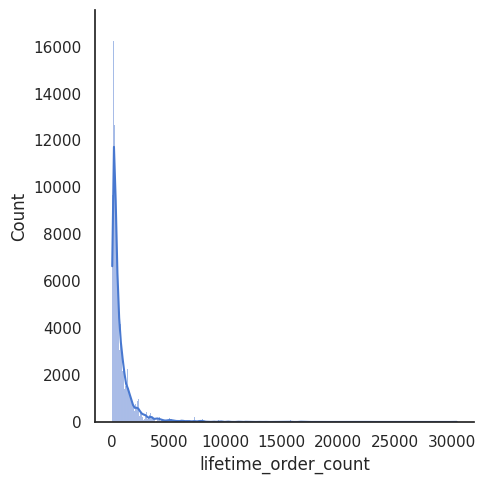

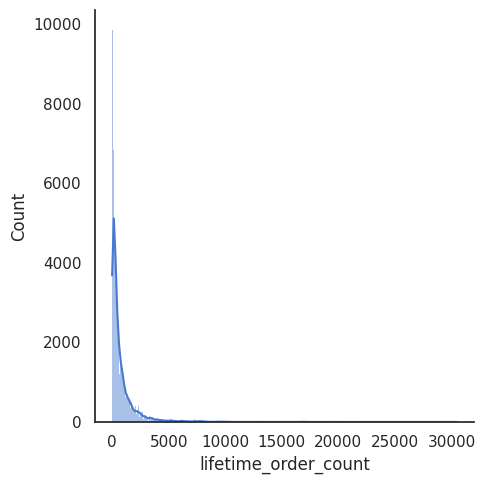

In [44]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['lifetime_order_count'],kde=True)

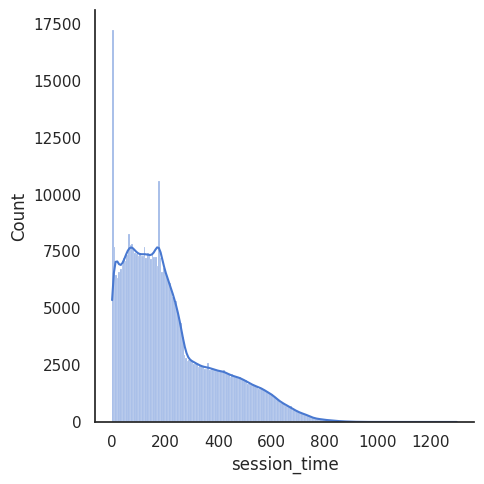

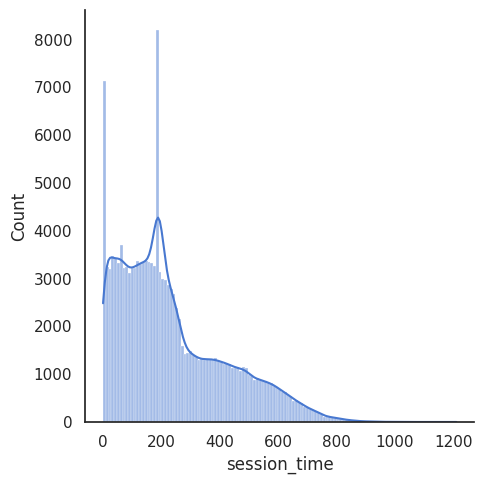

In [45]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['session_time'],kde=True)

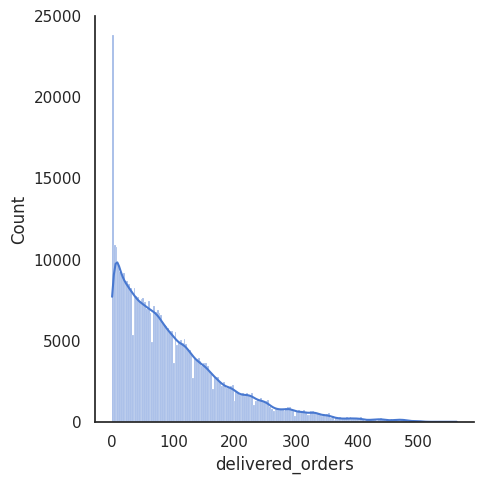

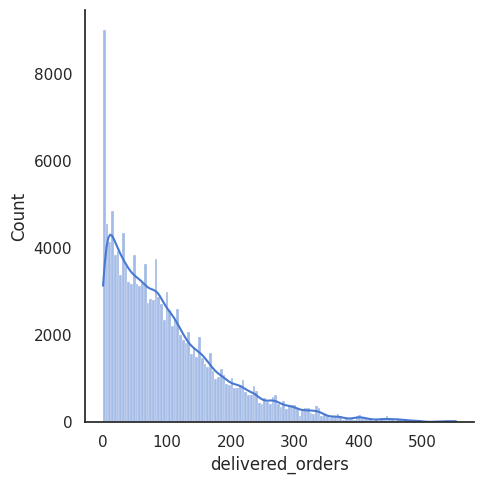

In [46]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['delivered_orders'],kde=True)

In [47]:
df['delivery_ratio'] = df['delivered_orders'] / df['lifetime_order_count']
test_df['delivery_ratio'] = test_df['delivered_orders'] / test_df['lifetime_order_count']

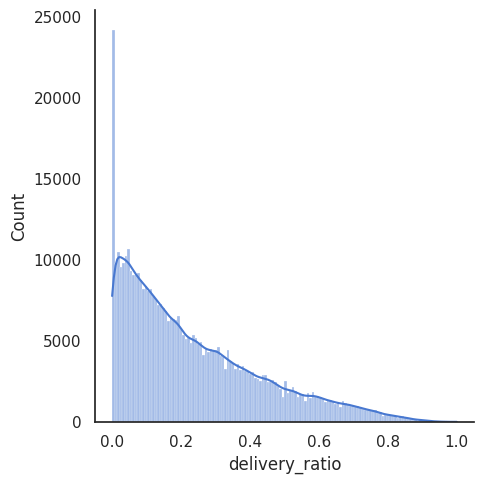

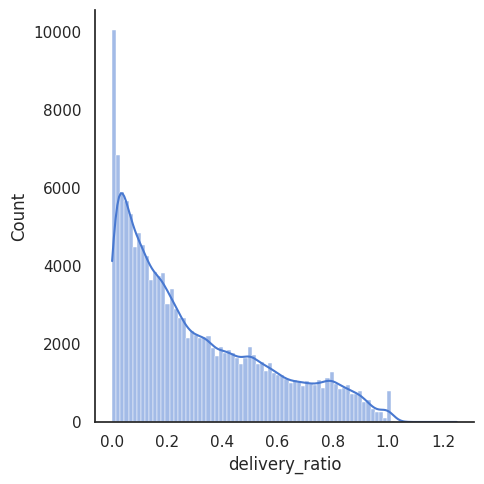

In [48]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['delivery_ratio'],kde=True)

In [49]:
df.isna().sum()

order_time                 0
delivered_orders           0
lifetime_order_count       0
session_time               0
day                      157
hour                     157
isWeekend                  0
last_first_mile_ratio      0
accept_order_time        157
accept_allot_time        157
total_distance             0
delivery_ratio             5
dtype: int64

In [50]:
test_df.isna().sum()

order_time                0
delivered_orders          0
lifetime_order_count      0
session_time              0
day                      68
hour                     68
isWeekend                 0
last_first_mile_ratio     0
accept_order_time        68
accept_allot_time        68
total_distance            0
delivery_ratio           42
dtype: int64

In [51]:
df['accept_order_time'].fillna(df['accept_order_time'].median(),inplace=True)
test_df['accept_order_time'].fillna(test_df['accept_order_time'].median(),inplace=True)

In [52]:
df['accept_allot_time'].fillna(df['accept_allot_time'].median(),inplace=True)
test_df['accept_allot_time'].fillna(test_df['accept_allot_time'].median(),inplace=True)

In [53]:
df.drop(['accept_allot_time','order_time'],axis=1,inplace=True)
test_df.drop(['accept_allot_time','order_time'],axis=1,inplace=True)


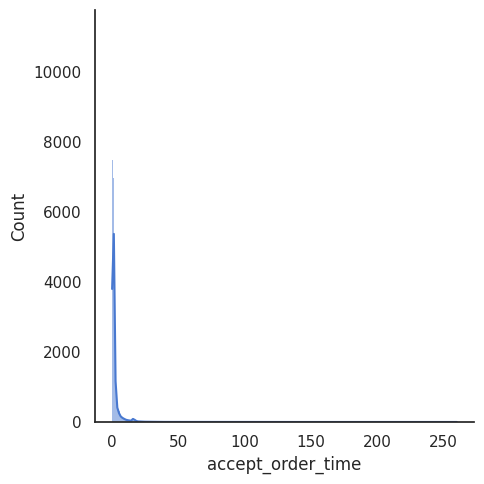

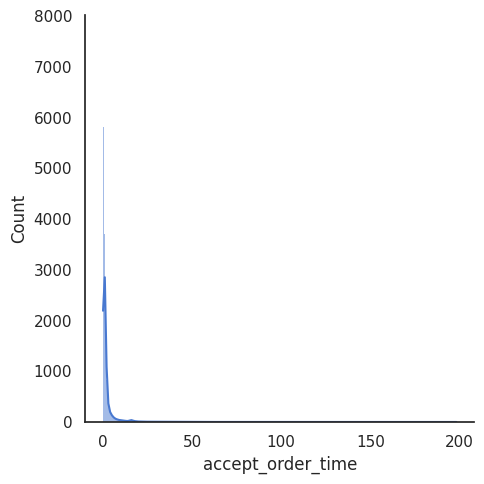

In [54]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['accept_order_time'],kde=True)

In [55]:
df['delivery_ratio'].fillna(0.0,inplace=True)
test_df['delivery_ratio'].fillna(0.0,inplace=True)

In [56]:
test_df.columns

Index(['delivered_orders', 'lifetime_order_count', 'session_time', 'day',
       'hour', 'isWeekend', 'last_first_mile_ratio', 'accept_order_time',
       'total_distance', 'delivery_ratio'],
      dtype='object')

In [57]:
df.drop(['hour','day'],axis=1,inplace=True)
test_df.drop(['hour','day'],axis=1,inplace=True)

In [58]:
test_df.isna().sum()

delivered_orders         0
lifetime_order_count     0
session_time             0
isWeekend                0
last_first_mile_ratio    0
accept_order_time        0
total_distance           0
delivery_ratio           0
dtype: int64

In [59]:
df.isna().sum()

delivered_orders         0
lifetime_order_count     0
session_time             0
isWeekend                0
last_first_mile_ratio    0
accept_order_time        0
total_distance           0
delivery_ratio           0
dtype: int64

In [60]:
X = df.copy()

In [61]:
X['class_label'] = Y

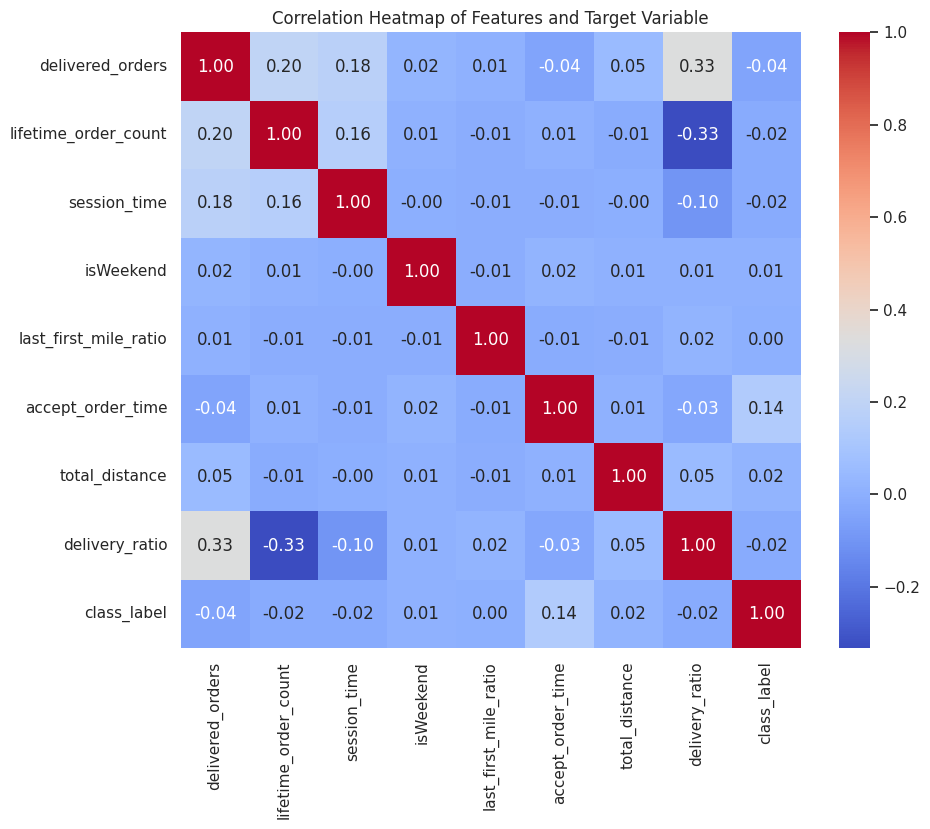

In [62]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features and Target Variable')
plt.show()

In [63]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(df, Y)

In [64]:
X_sm.shape

(889564, 8)

In [65]:
# Initialize XGBoost classifier
clf = XGBClassifier()

# Initialize stratified k-fold cross-validation
k_folds = 5  # Number of folds
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation results
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X_sm, y_sm):
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Train XGBoost classifier
    clf.fit(X_train, y_train.values.ravel())
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy and store
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print("accuracy = ",accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

accuracy =  0.7883291271576557
accuracy =  0.8142406681917567
accuracy =  0.8132570413629133
accuracy =  0.7956697936631949
accuracy =  0.8128119519762579
Mean Accuracy: 0.8048617164703558


In [66]:
submi = pd.read_csv('sample_submission.csv')
y_pred = clf.predict(test_df)
submi['cancelled'].value_counts()
submi['cancelled'] = y_pred
submi['cancelled'].value_counts()
submi.to_csv('submission_RDCP3.csv',index=False)
submi.head()

,order_id,cancelled
0,130231,0
1,130232,0
2,130233,0
3,130234,0
4,130235,0
